<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/12_gan/variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Diffusion Probabilistic Model (DDPM)

---
## 目的
Pytorchを用いてDenoising Diffusion Probabilistic Model (DDPM) を構築し，画像の生成を行う．

## モジュールのインポート

はじめに必要となるモジュールをインポートします．

### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`GPU availability: True`と表示されれば，GPUを使用した計算を行うことが可能です．
Falseとなっている場合は，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．

In [3]:
import math
import numpy as np
from inspect import isfunction
from functools import partial
from time import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from tqdm.auto import tqdm
from einops import rearrange
from einops.layers.torch import Rearrange

import torch
import torch.nn.functional as F
from torch import nn, einsum
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# # GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


## ネットワークの構築
DDPMは医療用画像のセマンティックセグメンテーションを行うモデルとして提案されたU-Netをベースにネットワークを構築しています．

また，DDPMのU-Netは以下の点でオリジナルのU-Netとは異なります．
* Position Embeddingsの追加
* Wide ResNetの採用
* Attentionの追加
* Group Normalizationの追加

これらを考慮してDDPMのネットワークを構築しますが，本ノートブックでは実装の簡略化のためWide ResNetではなく，通常のResNetを使用します．

## Position Embeddings
DDPMでは各時刻$t$のノイズを推定する時，ネットワークのパラメータは共通です．時刻$t$ごとにネットワークを構築するのではなく，どの時刻$t$かを表す情報をネットワークに与えることで各時刻$t$のノイズを推定することが可能となります．

Position Embeddingsでは以下に示す式によって時刻の特徴量を求め，U-Net層の各Residual blockに追加されます．
$$
PE_{(pos, 2i)} = \sin (\frac{pos}{10000^{(2i/d)}})
$$
$$
PE_{(pos, 2i+1)} = \cos (\frac{pos}{10000^{(2i/d)}})
$$
ここで，$pos$は時刻，$i$は時刻特徴量の次元のインデックス，$d$は時刻特徴量の次元数を表します．

In [4]:
class PositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

## ResNet Block
ResNetは，通常のネットワークのように，何かしらの処理ブロックによる変換$F(x)$を単純に次の層に渡していくのではなく，残差接続構造によりその処理ブロックへの入力$x$をショートカットし， $H(x) = F(x)+x$を次の層に渡すようにしています．残差接続構造により，誤差逆伝播時に勾配が消失しても，層をまたいで値を伝播することができます．このショートカットを含めた処理単位をResidual blockと呼びます．

DDPMのResNet Blockでは，Position Embeddingsで求めた時刻特徴量を画像特徴量に追加や残差接続を行います．ここで効率的な学習のために活性化関数にはRectified Linear Unit (ReLU)関数ではなく，Sigmoid-weighted Linear Unit (SiLU) 関数を用います．

In [5]:
# 補助関数
def exists(x):
    return x is not None

# 補助関数
def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# 残差接続
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

# アップサンプル
def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )

# ダウンサンプル
def Downsample(dim, dim_out=None):
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )

# 畳み込みブロック
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)
        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

# 残差接続ブロック
class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )
        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)

## Attention
DDPMでは，Dot-Product AttentionとLinear Attentionの2種類のAttentionをU-Netに追加しています．

#### Scaled Dot-Product Attention
Dot-Product Attentioとは，ある要素が他の要素にどれだけ注目するべきかを計算する手法であり，以下に示す式によって計算されます．
$$
\rm{Attention}(Q, K, V)= \rm{softmax} ( \frac{QK^{T}}{\sqrt{d_k} } ) V
$$
ここで，$Q, K, V$はそれぞれQuery，Key，Valueです．また$d_k$はQueryの次元数を表します．DDPMでは1つのQuery，Key，Valueを持たせるのではなく，小さいQuery，Key，Valueに分割して，分割した特徴表現を計算するMulti-Head Attentionを使用します．これにより，モデルが異なる特徴表現の異なる情報についてAttention weightを計算することが可能となります．

#### Linear Attention
Linear Attentionとは，シーケンス長$n$に対する計算コストを$O(n^2)$から$O(n)$へと削減した手法であり，以下に示す式によって計算されます
$$
\rm{LinearAttention} (Q, K, V) = \frac{\phi (Q) ( \phi (K)^T V)}{\phi (Q) \phi (K)^T}
$$
$$
\phi (x) = \rm{elu}(x) + 1
$$
ここで，$\rm{elu}(\cdot)$はExponential Linear Unit (ELU)関数を表します．Linear Attentionでは$K$と$V$の積を最初に計算し，次に$KV$と$Q$の積を計算します．これにより，内積計算が線形に抑えられ，計算コストはシーケンスの長さ$n$に対して$O(n)$となります．

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv)
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv)

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


## Group Normalization
Group Normalizationとは，チャネルを$G$個のグループに分割し，グループごとに１つの平均と分散を計算する正規化手法です．以下に正規化手法のイメージ図を示します．図からわかるように，Group NormalizationはLayer NormazliationとInstance Normalizationの中間のような正規化です．Layer Normazliationでは各チャネルの特徴を捉えられず，Instance Normalizationではチャネル間の依存関係を捉えられない場合でも，Group Normalizationではグループの特徴を捉えつつ，グループ内の依存関係もとらえることが可能です．

<img src="https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/3916683/ccf1ff69-8efc-c696-6798-982e32a8f554.png" width=100%>

In [7]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

## Unet
DDPMのU-Netでは，ノイズが付与された画像のバッチとそれぞれのノイズレベル（時刻$t$）を入力として受け取り，画像に追加されたノイズを推定しています．そのため，ネットワークの流れは以下のようになります．
* 最初に，ノイズが付与された画像に畳み込み処理と時刻$t$のPosition Embeddingsが計算されます．
* 次に，2つのResNet Block → Attention → 畳み込みの順番で処理されるダウンサンプリングが複数回適用されます．
* ネットワークの中央では，ResNet Block → Attention → ResNet Blockの順番で処理をします．
* アップサンプリングでは，2つのResNet Block → Attention → 畳み込みの順番を複数回処理をします．
* 最後に，ResNet Blockの後に畳み込み処理をします．

<img src="https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/3916683/23f56197-6977-9503-08fa-a39beda8012d.png" width=100%>

In [8]:
class Unet(nn.Module):
    def __init__(self, dim, init_dim=None, out_dim=None, dim_mults=(1, 2, 4, 8), channels=3, resnet_block_groups=4):
        super().__init__()
        self.channels = channels
        input_channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            PositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)
        # ダウンサンプリング
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )
        # 中間ブロック
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        # アップサンプリング
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)
            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)
        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time):
        x = self.init_conv(x)
        r = x.clone()
        t = self.time_mlp(time)
        h = []
        # ダウンサンプリング
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)
        # 中間ブロック
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)
        # アップサンプリング
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = torch.cat((x, r), dim=1)
        x = self.final_res_block(x, t)
        return self.final_conv(x)

## Forward Process
Forward Processは，入力画像$\mathbf{x}_0$に対してノイズを付与し最終的には完全なノイズ$\mathbf{x}_T$へと変換する確率過程であり，以下に示す式のように正規分布に従うマルコフ過程で定義されます．
$$
q(\mathbf{x}_{1:T} | \mathbf{x}_0) = \prod_{t=1}^T q(\mathbf{x}_t | \mathbf{x}_{t-1})
$$
$$
q(\mathbf{x}_t |  \mathbf{x}_{t-1}) = N(\mathbf{x}_t ; \sqrt{1 - \beta_t} \mathbf{x}_{t-1} \mathbf{I})
$$
ここで，$\beta_t$は変化量を表すパラメータを表します．Forward Processでは学習を行わず，単純に連続的な微小変化によって解析可能な分布に変換することが目的です．ノイズ量を調整するスケジューラの値は$0.0001 \sim 0.02$，ノイズを付与するステップは$300$回とします．

<img src="https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/3916683/44f8adec-7e88-557e-125d-3c5148616cc8.png" width=100%>

In [9]:
# スケジューラ
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

# ステップ数
timesteps = 300

betas = linear_beta_schedule(timesteps=timesteps)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


## Reverse Process
変化量を表すパラメータ$\beta_t$が十分に小さい連続変換（Forward Process）の場合，その逆変換（Reverse Process）は同じ関数系で表現することが可能であり，ガウスノイズの除去として考えることができます．そのため，Reverse Processは以下に示す式のように定義します．
$$
p_\theta (\mathbf{x}_{0:T}) = p_\theta (\mathbf{x}_T) \prod_{t=1}^T p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t)
$$
$$
p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t) = N( \mathbf{x}_{t-1}; \mathbf{\mu}_\theta (\mathbf{x}_t, t), \Sigma_\theta(\mathbf{x}_t, t))
$$
上記の式では，平均$\mathbf{\mu}_\theta$と共分散$\Sigma_\theta(\mathbf{x}_t, t)$をニューラルネットワークで学習することになっていますが，論文では共分散$\Sigma_\theta(\mathbf{x}_t, t)$をあらかじめ固定し学習しません．そのため，本ノートブックでは共分散を固定して実装していますが，ステップ数$t$を減らした場合においては平均と共分散の両方を学習した方が良いです．

<img src="https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/3916683/68d24842-f3bc-0905-9588-9b279365484a.png" width=100%>

In [10]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def p_sample_loop(model, shape, img_input=None):
    device = next(model.parameters()).device
    b = shape[0]
    if img_input == None:
        print('noise')
        img = torch.randn(shape, device=device)
    else:
        print('image')
        img = img_input
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3, img_input=None):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size), img_input=img_input)


## 損失関数
DDPMでは，Variational Autoencoderと同様にデータ$\mathbf{x}_0$の対数尤度の変分下限を最大化するように学習します．DDPMの損失関数は以下に示す式のようになります．
$$
\mathcal{L}_{\rm{simple}} = \mathbb{E}_{t, \mathbf{x}_0, \epsilon} [\parallel \epsilon - \epsilon_\theta(\sqrt{\bar{a}_t} \mathbf{x}_0 + \sqrt{1 - \bar{a}_t}\epsilon, t) \parallel^2]
$$
ここで，$\mathbf{x}_t = \sqrt{\bar{a}_t} \mathbf{x}_0 + \sqrt{1 - \bar{a}_t}\epsilon$と表せるため，損失関数は以下のようになります．
$$
\mathcal{L}_{\rm{simple}} = \mathbb{E}_{t, \mathbf{x}_0, \epsilon} [\parallel \epsilon - \epsilon_\theta(\mathbf{x}_t, t) \parallel^2]
$$
従ってDDPMでは，ノイズが付与された画像$\mathbf{x}_t$と時刻$t$が入力され，付与されたノイズ$\epsilon$を推定するニューラルネットワーク$\epsilon_\theta$を学習します．

In [11]:
def p_losses(denoise_model, x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)
    loss = F.smooth_l1_loss(noise, predicted_noise)
    return loss

## データセット，最適化関数などの設定
データセットはMNISTを用いて学習をします．
最適化関数にはAdam Optimizerを使用します．

In [12]:
# データセットの設定
transform_train = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, transform=transform_train, download=True)
train_loader = DataLoader(dataset=mnist_data, batch_size=128, shuffle=True)

mnist_testdata = datasets.MNIST(root='./data', train=False, transform=transform_train)
test_loader =DataLoader(dataset=mnist_testdata, batch_size=1, shuffle=True)


image_size = 28
channels = 1
epochs = 6

# ネットワークモデル・最適化手法の設定
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 11565469.38it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 345616.14it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 3182236.71it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 3240436.94it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## ネットワークの学習

In [13]:
model.train()

start = time()
for epoch in range(epochs):
    sum_loss = 0.0
    for x, _ in train_loader:
        optimizer.zero_grad()
        batch_size = x.shape[0]
        x = x.to(device)
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        loss = p_losses(model, x, t)
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()

    print("epoch:{}, Loss:{}, elapsed time: {}".format(epoch, sum_loss / len(train_loader), time() - start))

epoch:0, Loss:0.035871712377727794, elapsed time: 72.25571727752686
epoch:1, Loss:0.01660529750663398, elapsed time: 143.80867505073547
epoch:2, Loss:0.014912712506886357, elapsed time: 215.35305762290955
epoch:3, Loss:0.014045411194644884, elapsed time: 286.9498610496521
epoch:4, Loss:0.013613947039680567, elapsed time: 358.6327795982361
epoch:5, Loss:0.013388846591829873, elapsed time: 430.1505665779114


## 学習済みモデルを用いたノイズからの画像生成

先ほど学習した重みパラメータを用いて，ノイズから画像の生成をします．mnistの画像サイズと同じランダムなノイズを作成し，その値をモデルに入力した結果を確認します．

noise


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

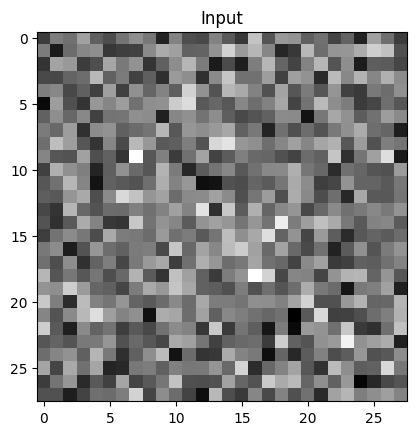

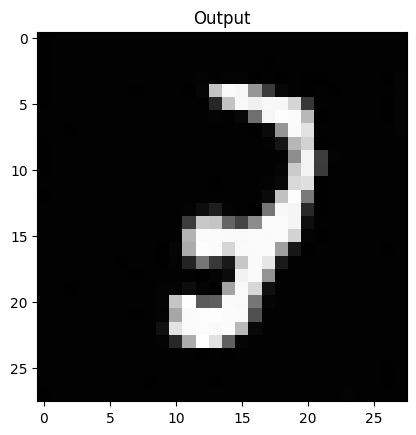

In [14]:
model.eval()
with torch.no_grad():
    # ノイズからのサンプリング
    samples = sample(model, image_size=image_size, batch_size=1, channels=channels)

plt.imshow(samples[0].reshape(image_size, image_size, channels), cmap="gray")
plt.title("Input")
plt.show()
plt.imshow(samples[-1].reshape(image_size, image_size, channels), cmap="gray")
plt.title("Output")
plt.show()

## デノイジングの可視化

先ほど生成した画像のデノイジング過程 (Reverse Process) を可視化して確認します．

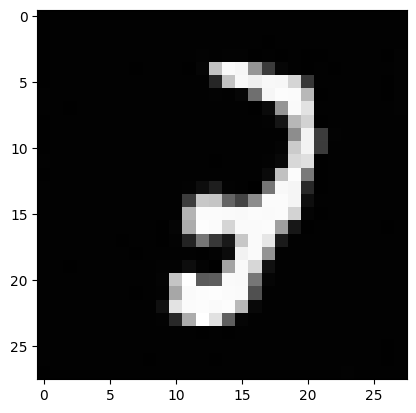

In [15]:
fig = plt.figure()
ims = []
for i in range(timesteps):
    if i % 50 == 0 or i == 299:
        im = plt.imshow(samples[i].reshape(image_size, image_size, channels), cmap="gray", animated=True)
        ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
HTML(animate.to_jshtml())

# ノイズからの画像生成
5つのノイズから画像を5枚生成し，どのような画像が生成されるか確認します．

noise


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

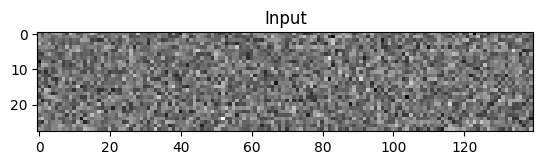

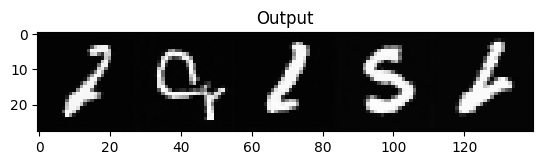

In [16]:
model.eval()
with torch.no_grad():
    samples = sample(model, image_size=image_size, batch_size=5, channels=channels)

input_imgs = np.concatenate([samples[0][i].reshape(image_size, image_size) for i in range(5)], axis=1)
output_imgs = np.concatenate([samples[-1][i].reshape(image_size, image_size) for i in range(5)], axis=1)

plt.imshow(input_imgs, cmap="gray")
plt.title("Input")
plt.show()
plt.imshow(output_imgs, cmap="gray")
plt.title("Output")
plt.show()

# 課題

1. 拡散過程を適用していない画像に対してデノイジング過程を適用し，どのような画像が生成されるか確認してみましょう．

image


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

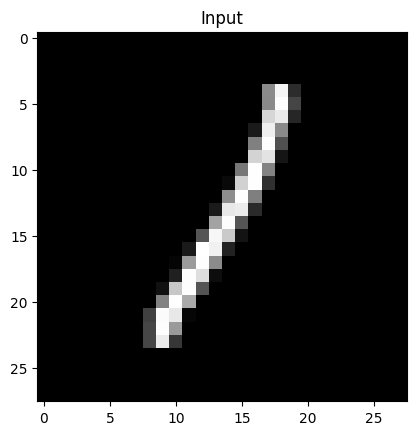

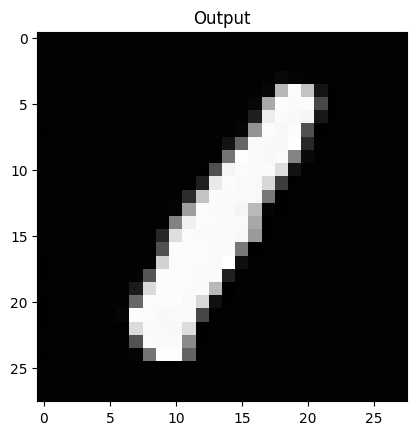

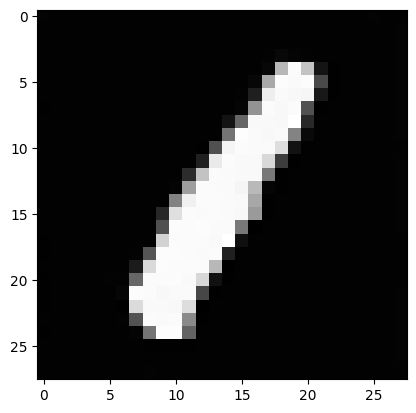

In [17]:
# ノイズが付与されていない画像に対してデノイジング過程を適用するには以下のようにします．

model.eval()
with torch.no_grad():
    x, y = next(iter(test_loader))
    samples = sample(model, image_size=image_size, batch_size=1, channels=channels, img_input=x.cuda())

plt.imshow(x.reshape(image_size, image_size, channels), cmap="gray")
plt.title("Input")
plt.show()
plt.imshow(samples[-1].reshape(image_size, image_size, channels), cmap="gray")
plt.title("Output")
plt.show()

fig = plt.figure()
ims = []
for i in range(timesteps):
    if i % 50 == 0 or i == 299:
        im = plt.imshow(samples[i].reshape(image_size, image_size, channels), cmap="gray", animated=True)
        ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
HTML(animate.to_jshtml())

2. 拡散過程のステップ数を変更して学習した際にどのような傾向が現れるか確認してみましょう．

ヒント：拡散過程のステップ数を変更したい場合，Forward Processのセルで定義されているtimestepsを変更する．

# 参考文献
[1] Jonathan Ho, Ajay Jain and Pieter Abbeel, Denoising Diffusion Probabilistic Models, NeurIPS, 2020.